# Modeling and Simulation in Python

Chapter 5: Design

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [146]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# To switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

### SIR implementation

We'll use a `State` object to represent the number or fraction of people in each compartment.

In [147]:
init = State(S=89, I=1, R=0)
init

,value
S,89
I,1
R,0


To convert from number of people to fractions, we divide through by the total.

In [148]:
init /= sum(init)
init

,value
S,0.988889
I,0.011111
R,0.000000


`make_system` creates a `System` object with the given parameters.

In [149]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

Here's an example with hypothetical values for `beta` and `gamma`.

In [150]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)

The update function takes the state during the current time step and returns the state during the next time step.

In [151]:
def update1(state, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

To run a single time step, we call it like this:

In [152]:
state = update1(init, system)
state

,value
S,0.985226
I,0.011996
R,0.002778


Now we can run a simulation by calling the update function for each time step.

In [153]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    system: System object
    update_func: function that updates state
    
    returns: State object for final state
    """
    state = system.init
    for t in linrange(system.t0, system.t_end):
        state = update_func(state, system)
    return state

The result is the state of the system at `t_end`

In [154]:
run_simulation(system, update1)

,value
S,0.520453
I,0.000615
R,0.478933


**Exercise**  Suppose the time between contacts is 4 days and the recovery time is 5 days.  After 14 weeks, how many students, total, have been infected?

Hint: what is the change in `S` between the beginning and the end of the simulation?

In [155]:
# Solution goes here
%matplotlib inline
from modsim import *

init = State(S = 89, I = 1, R = 0)
init /= sum(init)

def make_system(beta, gamma, weeks = 14):
    init = State(S = 89, I = 1, R = 0)
    init /= sum(init)
    t0 = 0
    t_end = 7 * weeks
    return System(init = init, t0 = t0, t_end = t_end, beta=beta, gamma=gamma)

tc = 4
tr = 5

beta = 1/tc
gamma = 1/tr

system = make_system(beta, gamma)
i0 = system.init.S

def update1(state, system):
    s, i, r = state
    
    infected = system.beta * i * s
    recovered = system.gamma * i
    
    i += infected - recovered
    r += recovered
    s -= infected
    return State(S = s, I = i, R = r)

def run_simulation(system, update_func):
    state = system.init
    for t in linrange(system.t0, system.t_end):
        state = update1(state, system)
    return state

state = run_simulation(system, update1)
ifinal = state.S
i0 - ifinal

0.37943042989926101

### Using Series objects

If we want to store the state of the system at each time step, we can use one `TimeSeries` object for each state variable.

In [156]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add three Series objects to the System: S, I, R
    
    system: System object
    update_func: function that updates state
    """
    S = TimeSeries()
    I = TimeSeries()
    R = TimeSeries()

    state = system.init
    t0 = system.t0
    S[t0], I[t0], R[t0] = state
    
    for t in linrange(system.t0, system.t_end):
        state = update_func(state, system)
        S[t+1], I[t+1], R[t+1] = state
    
    system.S = S
    system.I = I
    system.R = R

Here's how we call it.

In [157]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)
run_simulation(system, update1)

And then we can plot the results.

In [115]:
def plot_results(S, I, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', color='blue', label='Susceptible')
    plot(I, '-', color='red', label='Infected')
    plot(R, ':', color='green', label='Recovered')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

Here's what they look like.

In [116]:
plot_results(system.results.S, system.reults.I, system.results.R)
#savefig('chap05-fig01.pdf')

AttributeError: 'System' object has no attribute 'results'

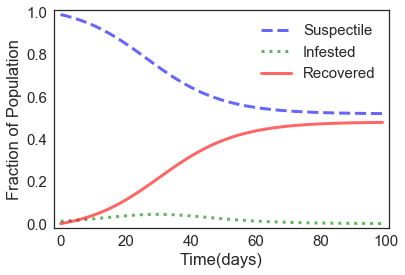

In [117]:
def run_simulation1(system, update_func):
    S = TimeSeries()
    I = TimeSeries()
    R = TimeSeries()
    
    state = system.init
    t0 = system.t0
    S[t0], I[t0], R[t0] = state
    
    for t in linrange(system.t0, system.t_end):
        state = update_func(state, system)
        S[t+1], I[t+1], R[t+1] = state
        
    system.S = S
    system.I = I
    system.R = R
    
run_simulation1(system, update1)

def plot_variation(system):
    plot(system.S, 'b--', label = 'Suspectile')
    plot(system.I, 'g:', label = 'Infested')
    plot(system.R, 'r-', label = 'Recovered')
    decorate(xlabel = 'Time(days)',
             ylabel = 'Fraction of Population',
             legend = True)
plot_variation(system)

### Using a DataFrame

Instead of making three `TimeSeries` objects, we can use one `DataFrame`.

We have to use `loc` to indicate which row we want to assign the results to.  But then Pandas does the right thing, matching up the state variables with the columns of the `DataFrame`.

In [118]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a DataFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    frame = DataFrame(columns=system.init.index)
    frame.loc[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end):
        frame.loc[t+1] = update_func(frame.loc[t], system)
    
    system.results = frame

Here's how we run it, and what the result looks like.

In [119]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

sir = make_system(beta, gamma)
run_simulation(system, update1)
system.results.head()

,S,I,R
0,0.988889,0.011111,0.000000
1,0.985226,0.011996,0.002778
2,0.981287,0.012936,0.005777
3,0.977055,0.013934,0.009011
4,0.972517,0.014988,0.012494


We can extract the results and plot them.

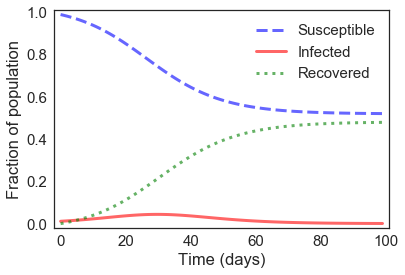

In [120]:
frame = system.results
plot_results(frame.S, frame.I, frame.R)

**Exercise**  Suppose the time between contacts is 4 days and the recovery time is 5 days.  Simulate this scenario for 14 days and plot the results.

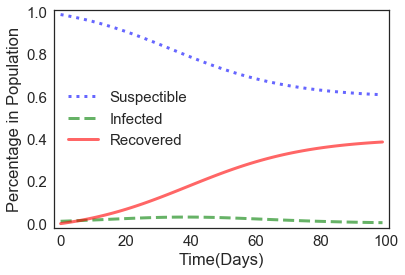

In [121]:
# Solution goes here
%matplotlib inline
from modsim import *
def make_system(beta, gamma, week = 14):
    init = State(S=89, I=1, R=0)
    init /= sum(init)
    t0 = 0 
    t_end = 7 * week
    return System(init = init, beta = beta, gamma = gamma, t0 = t0, t_end = t_end)

def update1(state, system):
    s, i, r = state
    
    infected = system.beta * i * s
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S = s, I = i, R = r)

tc = 4
tr = 5
beta = 1/tc
gamma = 1/tr

system = make_system(beta, gamma)

def run_simulation(system, update_func):
    frame = DataFrame(columns = system.init.index)
    frame.loc[system.t0] = system.init
    for i in linrange(system.t0, system.t_end):
        frame.loc[i+1] = update_func(state = frame.loc[i], system = system)
    system.results = frame

run_simulation(system, update1)
newfig()
plot(system.results.S, 'b:', label = 'Suspectible')
plot(system.results.I, 'g--', label = 'Infected')
plot(system.results.R, 'r-', label = 'Recovered')
decorate(xlabel = 'Time(Days)',
         ylabel = 'Percentage in Population',
         legend = True)

### Metrics

Given the results, we can compute metrics that quantify whatever we are interested in, like the total number of sick students, for example.

In [122]:
def calc_total_infected(system):
    """Fraction of population infected during the simulation.
    
    system: System object with results.
    
    returns: fraction of population
    """
    frame = system.results
    return frame.S[system.t0] - frame.S[system.t_end]

Here's an example.|

In [123]:
system.beta = 0.333
system.gamma = 0.25
run_simulation(system, update1)
print(system.beta, system.gamma, calc_total_infected(system))

0.333 0.25 0.467162931836


**Exercise:** Write functions that take a `System` object as a parameter, extract the `results` object from it, and compute the other metrics mentioned in the book:

1.  The fraction of students who are sick at the peak of the outbreak.

2.  The day the outbreak peaks.

3.  The fraction of students who are sick at the end of the semester.

Hint:  If you have a `TimeSeries` called `I`, you can compute the largest value of the series like this:

    I.max()

And the index of the largest value like this:

    I.idxmax()

You can read about these functions in the `Series` [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html).

In [124]:
# Solution goes here
def fraction_peak(system):
    peak_fraction = system.results.I.max()
    peak_time = system.results.I.idxmax()
    print('At Day', peak_time, ', the infection fraction reached its peak at', peak_fraction)
    
fraction_peak(system)

At Day 30 , the infection fraction reached its peak at 0.0435362026876


In [125]:
# Solution goes here
def sick_at_end(system):
    sick_fraction = system.results.I[system.t_end]
    print(sick_fraction)

In [126]:
# Solution goes here
sick_at_end(system)

0.000674194315603


In [127]:
# Solution goes here

In [128]:
# Solution goes here

In [129]:
# Solution goes here

### What if?

We can use this model to evaluate "what if" scenarios.  For example, this function models the effect of immunization by moving some fraction of the population from S to R before the simulation starts.

In [130]:
def add_immunization(system, fraction):
    """Immunize a fraction of the population.
    
    Moves the given fraction from S to R.
    
    system: System object
    fraction: number from 0 to 1
    """
    system.init.S -= fraction
    system.init.R += fraction

Let's start again with the system we used in the previous sections.

In [131]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)
system.beta, system.gamma

(0.3333333333333333, 0.25)

And run the model without immunization.

In [132]:
run_simulation(system, update1)
calc_total_infected(system)

0.46832081102878098

Now with 10% immunization.

In [133]:
system2 = make_system(beta, gamma)
add_immunization(system2, 0.5)
run_simulation(system2, update1)
calc_total_infected(system2)

0.019688715782459176

10% immunization leads to a drop in infections of 16 percentage points.

Here's what the time series looks like for S, with and without immunization.

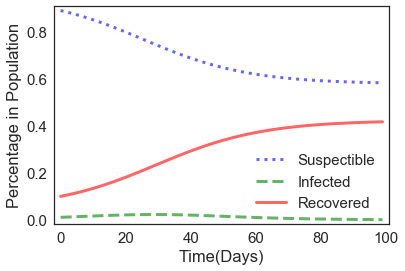

In [134]:
def add_immunization(system, fraction):
    system.init.S -= fraction
    system.init.R += fraction

tc = 3
tr = 4
beta = 1/tc
gamma = 1/tr
system = make_system(beta, gamma)
add_immunization(system, 0.1)
run_simulation(system, update1)
plot(system.results.S, 'b:', label = 'Suspectible')
plot(system.results.I, 'g--', label = 'Infected')
plot(system.results.R, 'r-', label = 'Recovered')
decorate(xlabel = 'Time(Days)',
         ylabel = 'Percentage in Population',
         legend = True)

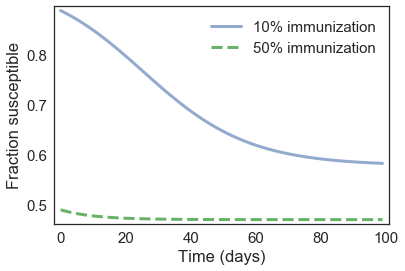

In [135]:
plot(system.results.S, '-', label='10% immunization')
plot(system2.results.S, 'g--', label='50% immunization')

decorate(xlabel='Time (days)',
         ylabel='Fraction susceptible')

#savefig('chap05-fig02.pdf')

Now we can sweep through a range of values for the fraction of the population who are immunized.

In [136]:
immunize_array = linspace(0, 1, 11)
for fraction in immunize_array:
    system = make_system(beta, gamma)
    add_immunization(system, fraction)
    run_simulation(system, update1)
    print(fraction, calc_total_infected(system))

0.0 0.468320811029
0.1 0.30650802854
0.2 0.161365457006
0.3 0.0728155898425
0.4 0.035520216753
0.5 0.0196887157825
0.6 0.0116220579983
0.7 0.00683873780062
0.8 0.00369649625371
0.9 0.00148153267227
1.0 -0.000161212109412


This function does the same thing and stores the results in a `Sweep` object.

In [137]:
def sweep_immunity(immunize_array):
    """Sweeps a range of values for immunity.
    
    immunize_array: array of fraction immunized
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    for fraction in immunize_array:
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        run_simulation(system, update1)
        sweep[fraction] = calc_total_infected(system)
    return sweep

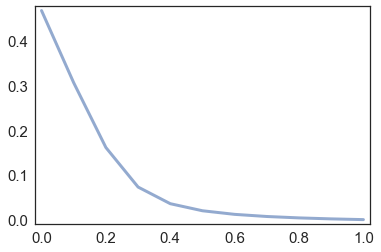

In [138]:
def sweep_immunity(immunize_array):
    sweep = SweepSeries()
    for fraction in immunize_array:
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        run_simulation(system, update1)
        sweep[fraction] = calc_total_infected(system)
    return sweep
immunize_array = linspace(0, 1, 11)
sweep = sweep_immunity(immunize_array)
plot(sweep)

Here's how we run it.

In [139]:
immunize_array = linspace(0, 1, 21)
infected_sweep = sweep_immunity(immunize_array)

And here's what the results look like.

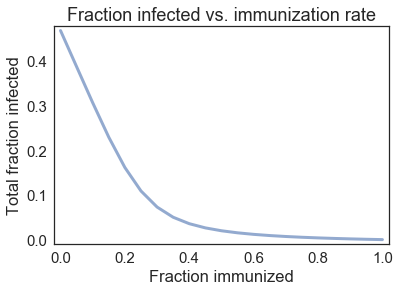

In [140]:
plot(infected_sweep)

decorate(xlabel='Fraction immunized',
         ylabel='Total fraction infected',
         title='Fraction infected vs. immunization rate',
         legend=False)

#savefig('chap05-fig03.pdf')

If 40% of the population is immunized, less than 4% of the population gets sick.

### Logistic function

To model the effect of a hand-washing campaign, I'll use a [generalized logistic function](https://en.wikipedia.org/wiki/Generalised_logistic_function), which is a convenient function for modeling curves that have a generally sigmoid shape.  The parameters of the GLF correspond to various features of the curve in a way that makes it easy to find a function that has the shape you want, based on data or background information about the scenario.

In [141]:
def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * exp(exponent)
    return A + (K-A) / denom ** (1/nu)

The following array represents the range of possible spending.

In [ ]:
spending = linspace(0, 1200, 21)
spending

`compute_factor` computes the reduction in `beta` for a given level of campaign spending.

`M` is chosen so the transition happens around \$500.

`K` is the maximum reduction in `beta`, 20%.

`B` is chosen by trial and error to yield a curve that seems feasible.

In [ ]:
def compute_factor(spending):
    """Reduction factor as a function of spending.
    
    spending: dollars from 0 to 1200
    
    returns: fractional reduction in beta
    """
    return logistic(spending, M=500, K=0.2, B=0.01)

Here's what it looks like.

In [ ]:
percent_reduction = compute_factor(spending) * 100

plot(spending, percent_reduction)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate',
         legend=False)

#savefig('chap05-fig04.pdf')

**Exercise:** Modify the parameters `M`, `K`, and `B`, and see what effect they have on the shape of the curve.  Read about the [generalized logistic function on Wikipedia](https://en.wikipedia.org/wiki/Generalised_logistic_function).  Modify the other parameters and see what effect they have.

In [ ]:
"""Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
"""
def compute_factor(spending):
    return logistic(spending, M=200, K=0.2, B = 0.01)
percent_reduction = compute_factor(spending) * 100
plot(spending, percent_reduction)
decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate',
         legend=False)

In [ ]:
def compute_factor(spending):
    return logistic(spending, M=500, K=0.2, B = 0.01, Q = -20)
percent_reduction = compute_factor(spending) * 100
plot(spending, percent_reduction)
decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate',
         legend=False)

### Hand washing

Now we can model the effect of a hand-washing campaign by modifying `beta`

In [ ]:
def add_hand_washing(system, spending):
    """Modifies system to model the effect of hand washing.
    
    system: System object
    spending: campaign spending in USD
    """
    factor = compute_factor(spending)
    system.beta *= (1 - factor)

Let's start with the same values of `beta` and `gamma` we've been using.

In [ ]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

beta, gamma

Now we can sweep different levels of campaign spending.

In [ ]:
spending_array = linspace(0, 1200, 13)

for spending in spending_array:
    system = make_system(beta, gamma)
    add_hand_washing(system, spending)
    run_simulation(system, update1)
    print(spending, system.beta, calc_total_infected(system))

Here's a function that sweeps a range of spending and stores the results in a `Sweep` object.

In [ ]:
def sweep_hand_washing(spending_array):
    """Run simulations with a range of spending.
    
    spending_array: array of dollars from 0 to 1200
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    for spending in spending_array:
        system = make_system(beta, gamma)
        add_hand_washing(system, spending)
        run_simulation(system, update1)
        sweep[spending] = calc_total_infected(system)
    return sweep

Here's how we run it.

In [ ]:
spending_array = linspace(0, 1200, 20)
infected_sweep = sweep_hand_washing(spending_array)

And here's what it looks like.

In [ ]:
plot(infected_sweep)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Total fraction infected',
         title='Effect of hand washing on total infections',
         legend=False)

#savefig('chap05-fig05.pdf')

Now let's put it all together to make some public health spending decisions.

In [ ]:
def add_hand_washing(system, spending):
    factor = compute_factor(spending)
    system.beta *= (1-factor)

spending_array = linspace(0, 1200, 20)
'''
for spending in spending_array:
    system = make_system(beta, gamma)
    add_hand_washing(system, spending)
    run_simulation(system, update1)
    print(spending, system.beta, calc_total_infected(system))
    '''
    
def sweep_hand_washing(spending_array):
    sweep = SweepSeries()
    for spending in spending_array:
        system = make_system(beta, gamma)
        add_hand_washing(system, spending)
        run_simulation(system, update1)
        sweep[spending] = calc_total_infected(system)
        #print(spending, system.beta, calc_total_infected(system))
    return sweep

sweep = sweep_hand_washing(spending_array)
plot(sweep, '-')
decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Total fraction infected',
         title='Effect of hand washing on total infections',
         legend=False)

### Optimization

Suppose we have \$1200 to spend on any combination of vaccines and a hand-washing campaign.

In [ ]:
num_students = 90
budget = 1200
price_per_dose = 100
max_doses = int(budget / price_per_dose)
dose_array = linrange(max_doses)
max_doses

We can sweep through a range of doses from, 0 to `max_doses`, model the effects of immunization and the hand-washing campaign, and run simulations.

For each scenario, we compute the fraction of students who get sick.

In [ ]:
for doses in dose_array:
    fraction = doses / num_students
    spending = budget - doses * price_per_dose
    
    system = make_system(beta, gamma)
    add_immunization(system, fraction)
    add_hand_washing(system, spending)
    
    run_simulation(system, update1)
    print(doses, system.init.S, system.beta, calc_total_infected(system))

The following function wraps that loop and stores the results in a `Sweep` object.

In [ ]:
def sweep_doses(dose_array):
    """Runs simulations with different doses and campaign spending.
    
    dose_array: range of values for number of vaccinations
    
    return: Sweep object with total number of infections 
    """
    sweep = SweepSeries()
    for doses in dose_array:
        fraction = doses / num_students
        spending = budget - doses * price_per_dose
        
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        add_hand_washing(system, spending)
        
        run_simulation(system, update1)
        sweep[doses] = calc_total_infected(system)

    return sweep

Now we can compute the number of infected students for each possible allocation of the budget.

In [ ]:
infected_sweep = sweep_doses(dose_array)

And plot the results.

In [ ]:
plot(infected_sweep)

decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses',
         legend=False)

#savefig('chap05-fig06.pdf')

In [ ]:
num_students = 90
budget = 1200
price_per_dose = 100
max_doses = int(budget / price_per_dose)
dose_array = linrange(max_doses)
max_doses

def sweep_doses(dose_array):
    sweep = SweepSeries()
    
    for dose in dose_array:
        fraction = dose / num_students
        spending = budget - dose * price_per_dose

        sir = make_system(beta, gamma)
        add_immunization(sir, fraction)
        add_hand_washing(sir, spending)
        
        run_simulation(sir, update1)
        sweep[dose] = calc_total_infected(sir)
        
    return sweep

sweep = sweep_doses(dose_array)
plot(sweep)

decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses',
         legend=False)

**Exercise:** Suppose the price of the vaccine drops to $50 per dose.  How does that affect the optimal allocation of the spending?

In [ ]:
num_students = 90
budget = 1200
price_per_dose = 50
max_doses = int(budget / price_per_dose)
dose_array = linrange(max_doses)
max_doses

def sweep_doses(dose_array):
    sweep = SweepSeries()
    for doses in dose_array:
        fraction = doses / num_students
        spending = budget - doses * price_per_dose
        
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        add_hand_washing(system, spending)
        
        run_simulation(system, update1)
        sweep[doses] = calc_total_infected(system)

    return sweep

sweep = sweep_doses(dose_array)
plot(sweep)

**Exercise:** Suppose we have the option to quarantine infected students.  For example, a student who feels ill might be moved to an infirmary, or a private dorm room, until they are no longer infectious.

How might you incorporate the effect of quarantine in the SIR model?

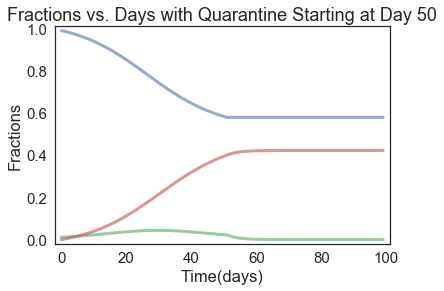

In [166]:
# Solution goes here
def update1(state, system, days_til_quarantine, days):
    """Update the SIR model.
    
    state: State with variables S, I, R
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r = state
    
    if days > days_til_quarantine:
        system.beta = 0
    
    infected = system.beta * i * s    
    recovered = system.gamma * i
    s -= infected
    #print(s)
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

def run_simulation(system, update_func, days_til_quarantine):
    frame = DataFrame(columns = system.init.index)
    frame.loc[system.t0] = system.init
    for days in linrange(system.t0, system.t_end):
        frame.loc[days+1] = update_func(frame.loc[days], system, days_til_quarantine, days)
    system.results = frame
    
def quarantine(days_til_quarantine):
    #sweep = SweepSeries()
    system = make_system(beta, gamma)
    run_simulation(system, update1, days_til_quarantine)
        #sweep[i] = system
    return system
        
        
a = quarantine(50).results
plot(a.S)
plot(a.I)
plot(a.R)
decorate(xlabel='Time(days)',
         ylabel='Fractions',
         title='Fractions vs. Days with Quarantine Starting at Day 50',
         legend=False)